In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
# os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

import keras
import numpy as np
from keras.models import Model, load_model
from keras.layers import Dense, Input, Activation, Flatten, Add
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.datasets import cifar10
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from keras import backend
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
(xx_train, yy_train), (x_test, y_test) = cifar10.load_data()
xx_train = xx_train.astype('float32')
x_test = x_test.astype('float32')

x_train = xx_train[:45000]
y_train = yy_train[:45000]
x_valid = xx_train[45000:50000]
y_valid = yy_train[45000:50000]

x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)
y_test = np_utils.to_categorical(y_test)

In [3]:
x_train.shape[1:]

(32, 32, 3)

In [4]:
traingen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')
traingen.fit(x_train)

In [5]:
def add(a,b):
    shape1 = backend.int_shape(a)
    shape2 = backend.int_shape(b)
    w = int(round(shape1[1]/shape2[1]))
    h = int(round(shape1[2]/shape2[2]))
    eq = shape1[3] == shape2[3]
    
    tmp = a
    print w,h,eq
    print shape1, shape2
    if w>1 or h>1 or not eq:
        tmp = Conv2D(filters=shape2[3],kernel_size=(1,1),strides=(w,h),padding='valid',kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(a)
    print backend.int_shape(tmp)
    print
    return Add()([tmp, b])

### Modified ResNet v2

In [7]:
def layer(num_filt, size, strides, inp):
    tmp = BatchNormalization(axis=3)(inp)
    tmp = Activation('relu')(tmp)
    tmp = Conv2D(num_filt, size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(tmp)
    return tmp

l = Input(x_train.shape[1:])

x = Conv2D(128, (7,7), strides=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(l)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)

#first layer
num = 32
xtmp = Conv2D(num, (1,1), strides=1, 
              padding='same', 
              kernel_initializer='he_normal', 
              kernel_regularizer=l2(0.0001))(x)
xtmp = layer(num, (3,3), 1, xtmp)
xtmp = layer(num*4, (1,1), 1, xtmp)

x = add(x,xtmp)

#other layer
xtmp = layer(num, (1,1), 1, x)
xtmp = layer(num, (3,3), 1, xtmp)
xtmp = layer(num*4, (1,1), 1, xtmp)
x = add(x,xtmp)

for i in xrange(9):
    xtmp = layer(num, (1,1), 1, x)
    xtmp = layer(num, (3,3), 1, xtmp)
    xtmp = layer(num*4, (1,1), 1, xtmp)
    x = add(x,xtmp)

    #other layer
    xtmp = layer(num, (1,1), 1, x)
    xtmp = layer(num, (3,3), 1, xtmp)
    xtmp = layer(num*4, (1,1), 1, xtmp)
    x = add(x,xtmp)

x = BatchNormalization()(x)
x = Activation('relu')(x)

xshape = backend.int_shape(x)
x = AveragePooling2D(pool_size=(xshape[1],xshape[2]), strides=(1,1))(x)
x = Flatten()(x)

x = Dense(10, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(x)

early=EarlyStopping(monitor='val_acc', patience=15, verbose=1, mode='auto')
filepath="weights-with-augmentation-val-acc-lr.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), monitor='val_acc', cooldown=0, patience=5, min_lr=0.5e-6)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 

In [8]:
model = Model(l,x)

model.compile(
    optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 16, 16, 128)  18944       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 16, 16, 128)  512         conv2d_62[0][0]                  
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 16, 16, 128)  0           batch_normalization_62[0][0]     
__________________________________________________________________________________________________
conv2d_63 

In [9]:
history = model.fit_generator(traingen.flow(x_train, y_train, batch_size=32),
                              steps_per_epoch=x_train.shape[0]//32, 
                              validation_data=(x_valid,y_valid),
                              epochs=200, 
                              verbose=1, 
                              max_queue_size=128,
                              shuffle=True,
                              callbacks=[checkpoint, early, lr_reducer])

Epoch 1/200
1406/1406 [==============================] - 3190s 2s/step - loss: 2.1450 - acc: 0.3845 - val_loss: 1.9264 - val_acc: 0.4194
Epoch 2/200
1406/1406 [==============================] - 3090s 2s/step - loss: 1.7434 - acc: 0.4831 - val_loss: 2.1180 - val_acc: 0.4090
Epoch 3/200
1406/1406 [==============================] - 3148s 2s/step - loss: 1.5843 - acc: 0.5180 - val_loss: 2.2441 - val_acc: 0.4420
Epoch 4/200
1406/1406 [==============================] - 3090s 2s/step - loss: 1.4863 - acc: 0.5472 - val_loss: 1.4555 - val_acc: 0.5660
Epoch 5/200
1406/1406 [==============================] - 1519s 1s/step - loss: 1.4082 - acc: 0.5722 - val_loss: 1.3711 - val_acc: 0.5754
Epoch 6/200
1406/1406 [==============================] - 1513s 1s/step - loss: 1.3451 - acc: 0.5972 - val_loss: 1.7228 - val_acc: 0.5218
Epoch 7/200
1406/1406 [==============================] - 1524s 1s/step - loss: 1.2988 - acc: 0.6120 - val_loss: 1.4445 - val_acc: 0.5850
Epoch 8/200
1406/1406 [==================

1406/1406 [==============================] - 1483s 1s/step - loss: 0.8433 - acc: 0.7788 - val_loss: 0.7150 - val_acc: 0.8216
Epoch 30/200
1406/1406 [==============================] - 1494s 1s/step - loss: 0.8266 - acc: 0.7814 - val_loss: 0.7270 - val_acc: 0.8220
Epoch 31/200
1406/1406 [==============================] - 1489s 1s/step - loss: 0.8154 - acc: 0.7848 - val_loss: 0.6934 - val_acc: 0.8276
Epoch 32/200
1406/1406 [==============================] - 1485s 1s/step - loss: 0.8032 - acc: 0.7874 - val_loss: 0.7081 - val_acc: 0.8184
Epoch 33/200
1406/1406 [==============================] - 1501s 1s/step - loss: 0.7901 - acc: 0.7905 - val_loss: 0.6837 - val_acc: 0.8296
Epoch 34/200
1406/1406 [==============================] - 1520s 1s/step - loss: 0.7807 - acc: 0.7920 - val_loss: 0.6690 - val_acc: 0.8332
Epoch 35/200
1406/1406 [==============================] - 1499s 1s/step - loss: 0.7725 - acc: 0.7958 - val_loss: 0.6678 - val_acc: 0.8336
Epoch 36/200
1406/1406 [=======================

1406/1406 [==============================] - 1823s 1s/step - loss: 0.6152 - acc: 0.8423 - val_loss: 0.5506 - val_acc: 0.8628
Epoch 59/200
1406/1406 [==============================] - 1825s 1s/step - loss: 0.6118 - acc: 0.8422 - val_loss: 0.5302 - val_acc: 0.8684
Epoch 60/200
1406/1406 [==============================] - 1835s 1s/step - loss: 0.6148 - acc: 0.8392 - val_loss: 0.5521 - val_acc: 0.8616
Epoch 61/200
1406/1406 [==============================] - 1839s 1s/step - loss: 0.5950 - acc: 0.8468 - val_loss: 0.5188 - val_acc: 0.8688
Epoch 62/200
1406/1406 [==============================] - 1838s 1s/step - loss: 0.5892 - acc: 0.8500 - val_loss: 0.5218 - val_acc: 0.8708
Epoch 63/200
1406/1406 [==============================] - 1823s 1s/step - loss: 0.5887 - acc: 0.8486 - val_loss: 0.5109 - val_acc: 0.8750
Epoch 64/200
1406/1406 [==============================] - 1827s 1s/step - loss: 0.5846 - acc: 0.8516 - val_loss: 0.5177 - val_acc: 0.8732
Epoch 65/200
1406/1406 [=======================

In [10]:
res = model.evaluate(x_test, y_test, batch_size=512)
print('Loss: %.2f Accuracy: %.2f%%' % (res[0], res[1]*100.0))

10000/10000 [==============================] - 117s 12ms/step
Loss: 0.53 Accuracy: 87.13%


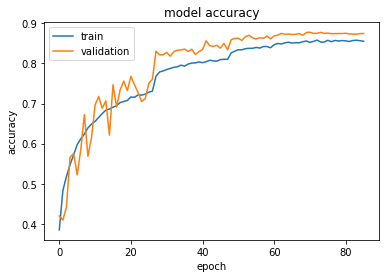

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

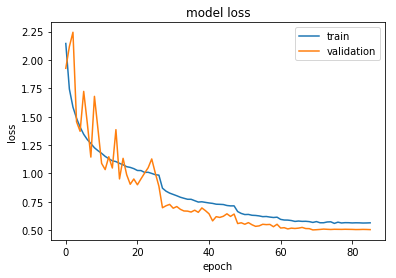

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()